In [64]:
import os
import matplotlib.pyplot as plt
import skimage
import numpy as np
from scipy import ndimage as ndi
from skimage import io
import pandas as pd
from pygrowthmodels import vonbertalanffy

# TODO:
    suavizar aneis
    confirmar se perfis estao bem traçados

In [62]:
dados = pd.DataFrame()
# importa nome dos ficheiros
lista = []
for file in os.listdir('photos/bios'):
    lista.append(file)
dados['file'] = lista
# extrai atributos dos ficheiros com base nos nomes
res = []
for name in dados['file']:
    res.append(name.split('-'))

dados['Lt'] = [item[5] for item in res]
dados['month'] = [item[3][2:5] for item in res]
# prepara idades
dados['age'] = 0
#limpeza
del lista, res

In [63]:
print(dados)

                                             file    Lt month  age
0       GUU-Deneb-Amo2-21Jan08-100-25,4-2-0,5.jpg  25,4   Jan    0
1       GUU-Deneb-Amo2-21Jan08-101-25,2-2-0,5.jpg  25,2   Jan    0
2         GUU-Deneb-Amo2-21Jan08-102-25-2-0,5.jpg    25   Jan    0
3       GUU-Deneb-Amo2-21Jan08-103-26,1-2-0,5.jpg  26,1   Jan    0
4     GUU-Deneb-Amo2-21Jan08-104-26,2-1,6-0,5.jpg  26,2   Jan    0
..                                            ...   ...   ...  ...
696  GUU-MardeLagos-Amo1-07Jan08-5-21,7-2-0,5.jpg  21,7   Jan    0
697  GUU-MardeLagos-Amo1-07Jan08-6-21,9-2-0,5.jpg  21,9   Jan    0
698  GUU-MardeLagos-Amo1-07Jan08-7-21,3-2-0,5.jpg  21,3   Jan    0
699  GUU-MardeLagos-Amo1-07Jan08-8-21,6-2-0,5.jpg  21,6   Jan    0
700  GUU-MardeLagos-Amo1-07Jan08-9-21,5-2-0,5.jpg  21,5   Jan    0

[701 rows x 4 columns]


In [7]:
teste_01 = io.imread('photos/bios/GUU-Draco-Amo9-29Mai70-515-29,1-2-0,5-DIR.jpg')
teste_02 = io.imread('photos/bios/GUU-Mar Roxo-Amo4-27Fev08-202-23,4-2,5-0,5-ESQ.jpg')
teste_03 = io.imread('photos/AM3 CL_20112018/CL19_20112018.jpg')
teste_04 = io.imread('photos/NOVAS FOTOS/0004.tif', plugin='pil')
teste_05 = io.imread('photos/bios/GUU-Deneb-Amo2-21Jan08-49-20,9-2-0,5.jpg')

# Função: Prototipo 1:

In [28]:
def processador(imagem, plot:bool=True):
    colapsado = skimage.color.rgb2gray(imagem)

    # prepara histograma para desenhar imagem
    histogram, bin_edges = np.histogram(colapsado, bins=100, range=(0, 1))

    # detecta a borda e cria uma mascara
    markers = np.zeros_like(colapsado)
    markers[colapsado < 0.1] = 1 # como determinar este valor?
    markers[colapsado> 0.8] = 2 # como determinar este valor?

    edge = skimage.filters.sobel(colapsado)
    segmentation_edge = skimage.segmentation.watershed(edge, markers)

    # limpeza do segmentation edge
    mascara = segmentation_edge-1

    # identifica o objecto maior
    otolito = skimage.filters.apply_hysteresis_threshold(colapsado*segmentation_edge, high = 0.6, low = 0.4) # validar valores
    labeled = ndi.label(otolito)[0]
    otolito = skimage.color.label2rgb(labeled, mascara)

    # identifica o centroide
    largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
    binary = labeled == largest_nonzero_label
    skeleton = skimage.morphology.skeletonize(binary)
    g, nodes = skimage.graph.pixel_graph(skeleton, connectivity=2)
    px, distances = skimage.graph.central_pixel(
    g, nodes=nodes, shape=skeleton.shape, partition_size=100)

    centroid = skimage.measure.centroid(labeled > 0)

    # identifica a borda pixel a pixel?
    borda = skimage.measure.find_contours(binary) # em vez de segmentation edge?

    # calcula extremo do rostro
    origin_x, origin_y = px[1], px[0]
    res = []
    for array in borda:
        for line in array:
            res.append(line.tolist())

    distancia = []
    for item in res:
        distancia.append(np.sqrt((origin_y-item[1])**2 + (origin_x-item[0])**2))
    max_index = distancia.index(max(distancia))
    extremo = res[max_index]

    # linha de perfil a partir do centroide
    profile = skimage.measure.profile_line(colapsado, src = (origin_x, origin_y), dst = (extremo[1],extremo[0]))

    # histograma do perfil; intuiçao para smoothing
    p_hist, p_bin = np.histogram(profile, bins=100, range=(0, 1))

    # plots
    if plot:
        f, ax = plt.subplots(3,3, figsize = (40,20))
        # imagem original em grayscale
        ax[0,0].imshow(colapsado, cmap = plt.cm.gray)
        # imagem original depois de retirar o fundo por watershed
        ax[0,1].imshow(colapsado * mascara, cmap = plt.cm.gray)
        # histograma da imagem original
        ax[0,2].plot(bin_edges[0:-1], histogram)
        # regiao do otolito determinada por hysteresis
        ax[1,0].imshow(otolito, cmap = plt.cm.gray)
        # centroide, borda e linha de perfil do otolito

        origin = [origin_x, extremo[1]]
        dest = [origin_y,extremo[0]]

        #ax[1,1].imshow(skimage.color.label2rgb(skeleton, colapsado*mascara)) # versao original com mascara
        ax[1,1].imshow(colapsado, cmap = plt.cm.gray)
        ax[1,1].plot(origin, dest, linewidth = 5, color = 'r')
        ax[1,1].scatter(px[1], px[0], label='graph center')
        ax[1,1].scatter(centroid[1], centroid[0], label='centroid')
        ax[1,1].legend()
        ax[1,1].set_axis_off()
        ax[1,1].set_title('graph center vs centroid')
        for contour in borda:
            ax[1,1].plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')

        # perfil desenhado do otolito
        ax[1,2].plot(profile)
        # histograma do perfil
        ax[2,0].plot(p_bin[0:-1], p_hist)

    return [p_bin, p_hist]

[array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 70, 31,  5,  4,  1,
         2,  1,  1,  1,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,
         0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  1,  1,  2,  1,
         1,  1,  1,  3, 20, 14,  9, 16, 14,  3,  5,  1,  1,  0,  0,  0,  0,
        

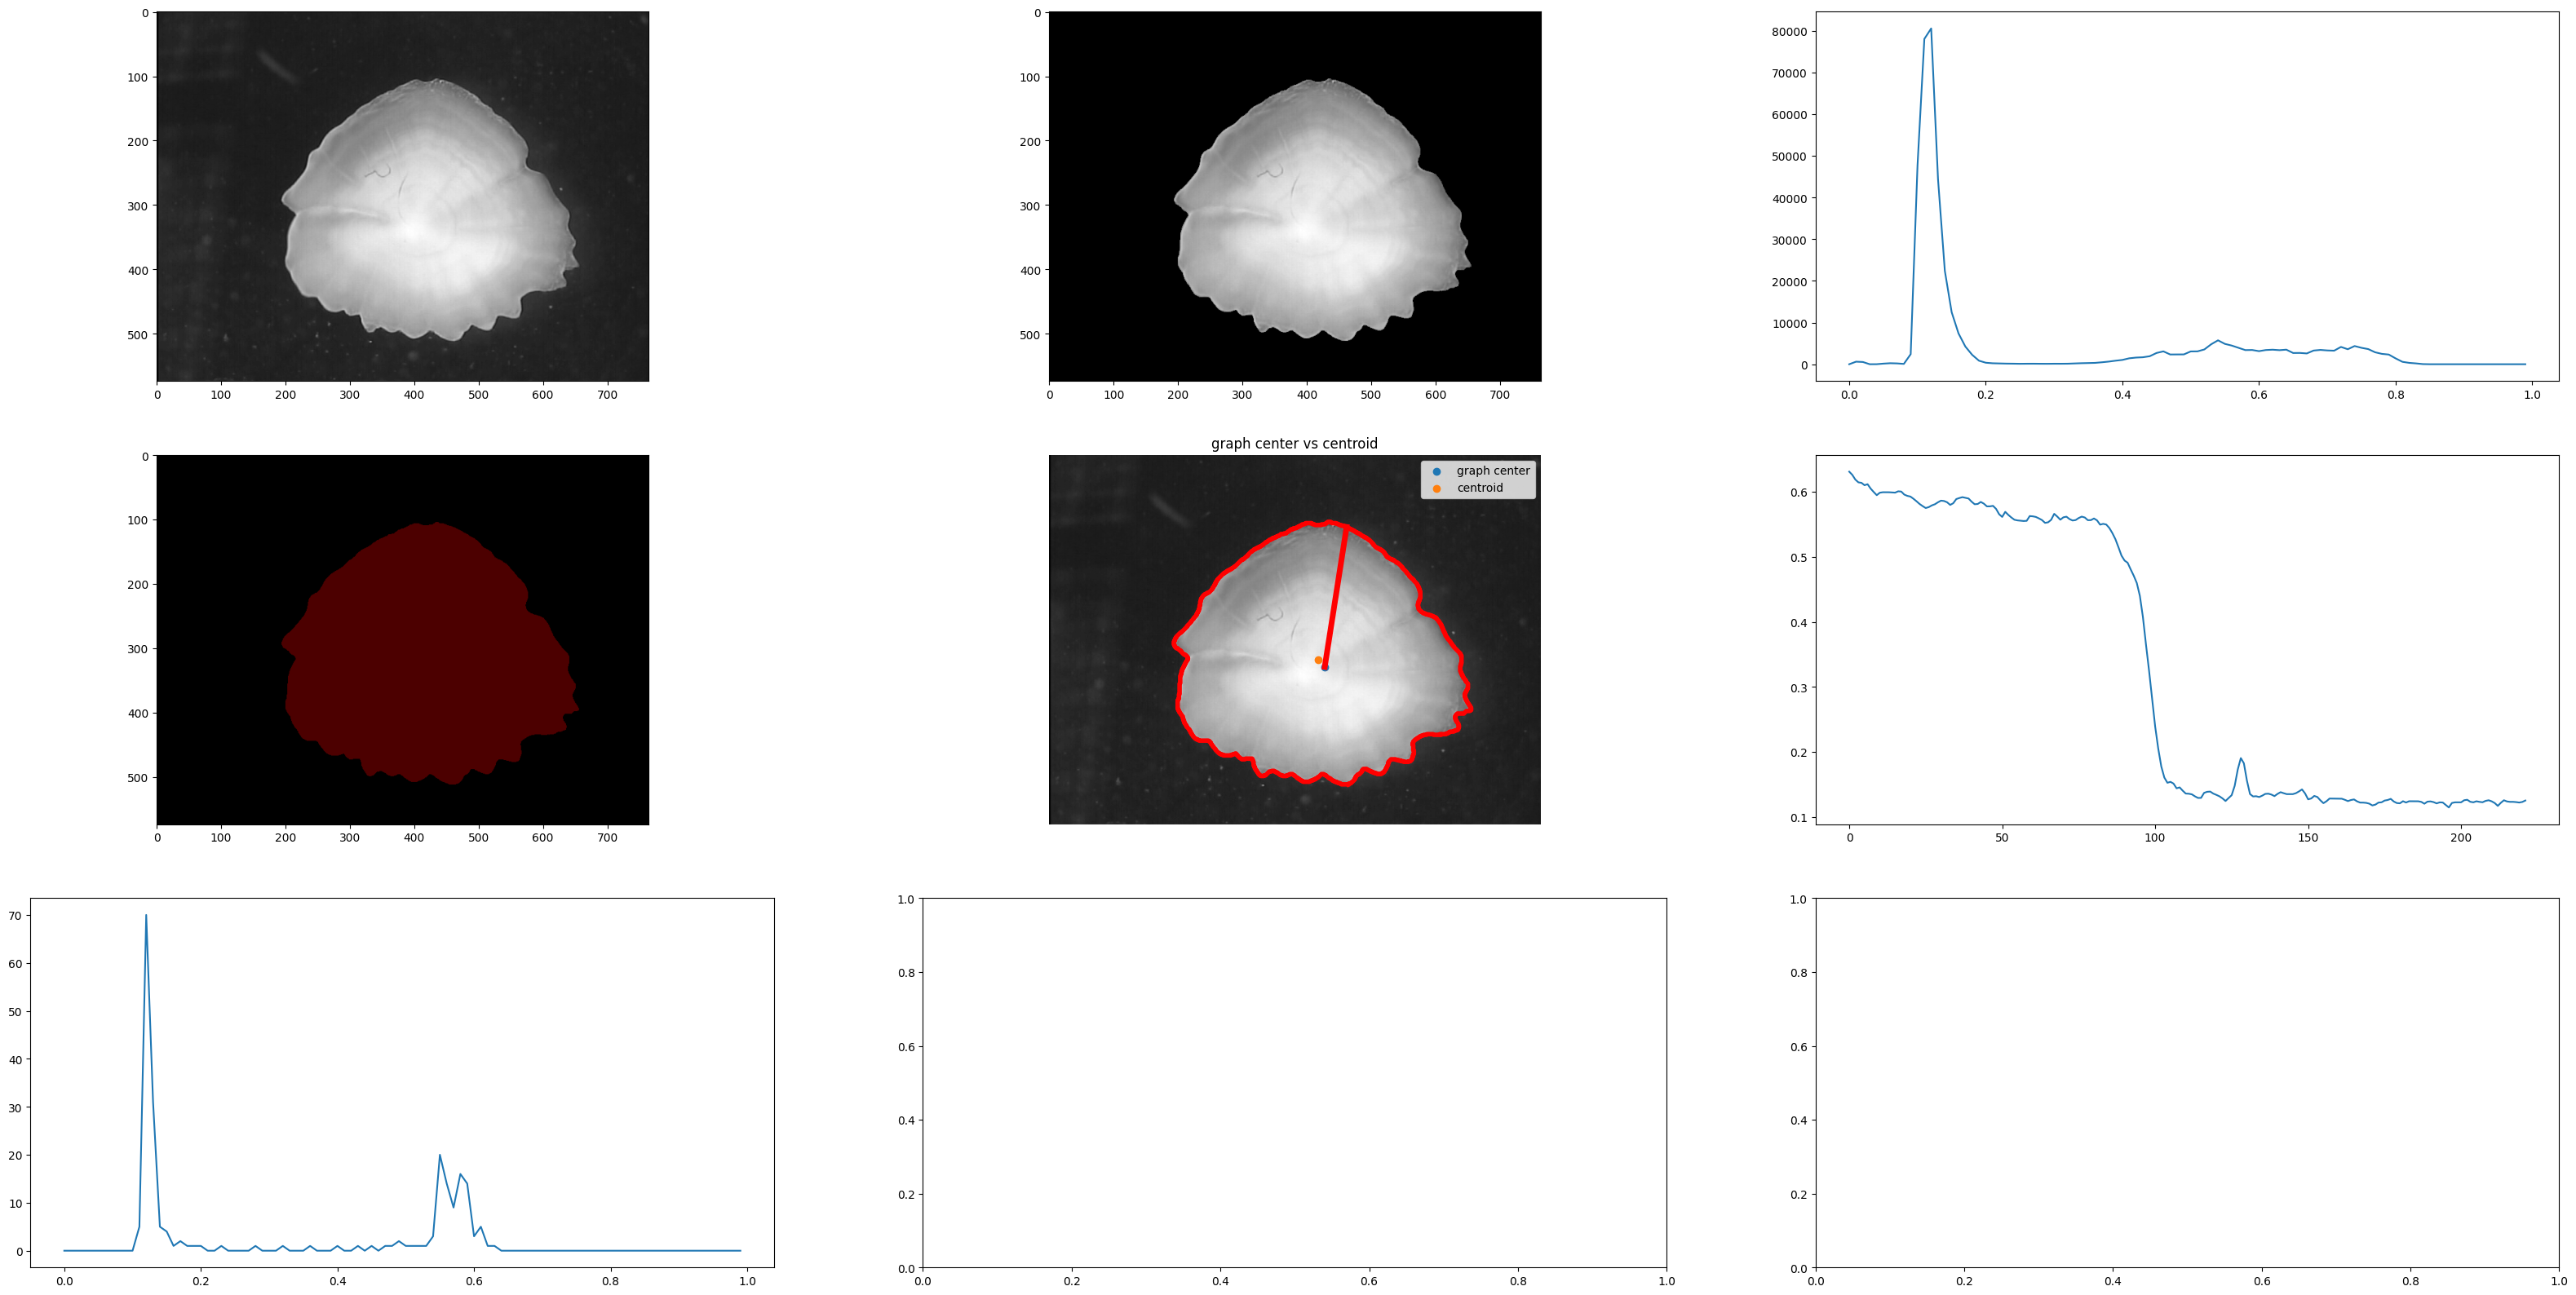

In [75]:
processador(teste_01, True)

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
http://olgahernand.free.fr/gallery_scripts/html/figure_python/von_Bertalanffy_plots.html

In [18]:
temp = processador(teste_01, False)

In [ ]:
temp

Validaçao e modelo de crescimento

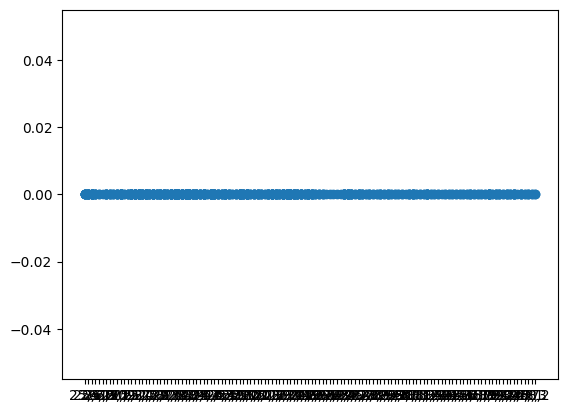

In [74]:
plt.scatter(dados['Lt'], dados['age'])

In [69]:
vonbertalanffy()

Object `vonbertalanffy()` not found.
